# Feature development and encoding of the Open University Learning Analytics Dataset (OULAD)

This is done for the Research Question 2. The target is to predict if a student will pass or fail a course, using only the information available in the first half of the course duration. 

We will create the features, present the reasoning, encode the data and save the dataset for later use.

In [52]:
import pandas as pd # import the used libraries within the collab
import pandas as pd
import numpy as np
import statistics
from sklearn.preprocessing import OrdinalEncoder

In [53]:
# reading the data from the tables
courses = pd.read_csv('../OULAD_dataset/courses.csv')
assessments = pd.read_csv('../OULAD_dataset/assessments.csv')
studentAssessment = pd.read_csv('../OULAD_dataset/studentAssessment.csv')
studentInfo = pd.read_csv('../OULAD_dataset/studentInfo.csv')
studentRegistration = pd.read_csv('../OULAD_dataset/studentRegistration.csv')
studentVle = pd.read_csv('../OULAD_dataset/studentVle.csv')
vle = pd.read_csv('../OULAD_dataset/vle.csv')

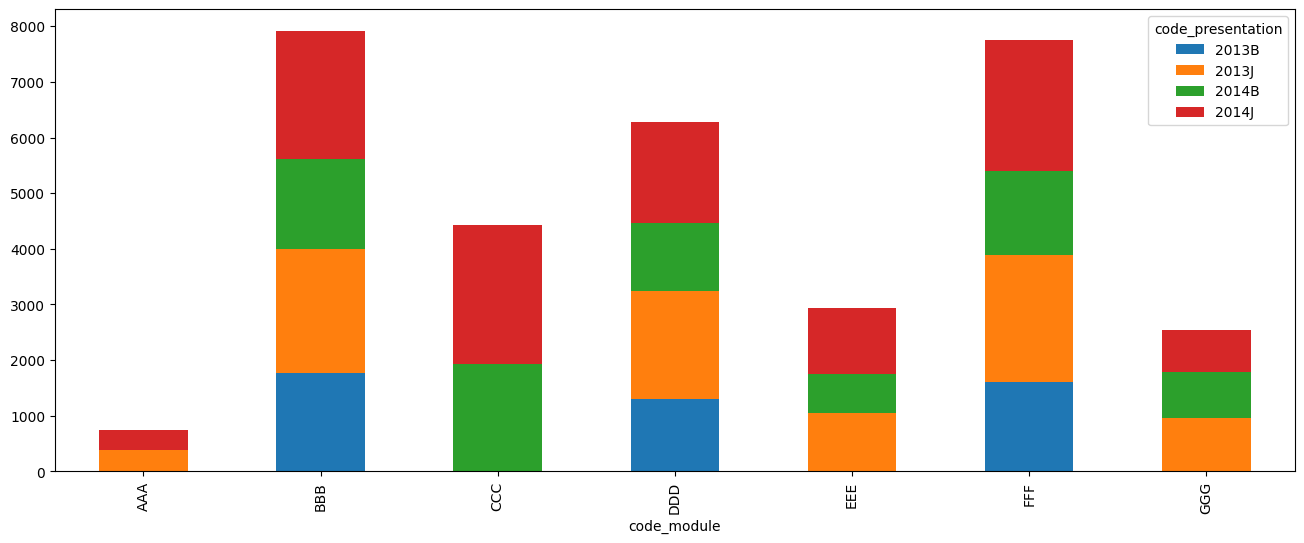

In [54]:
# Visualisation of the courses, in terms of the number of students and sessions
grouped = studentInfo.groupby(['code_module',	'code_presentation']).size().unstack().plot(kind='bar', stacked=True, figsize=(16, 6)) # number of students in each course module

['Pass' 'Withdrawn' 'Fail' 'Distinction']


<Axes: xlabel='final_result'>

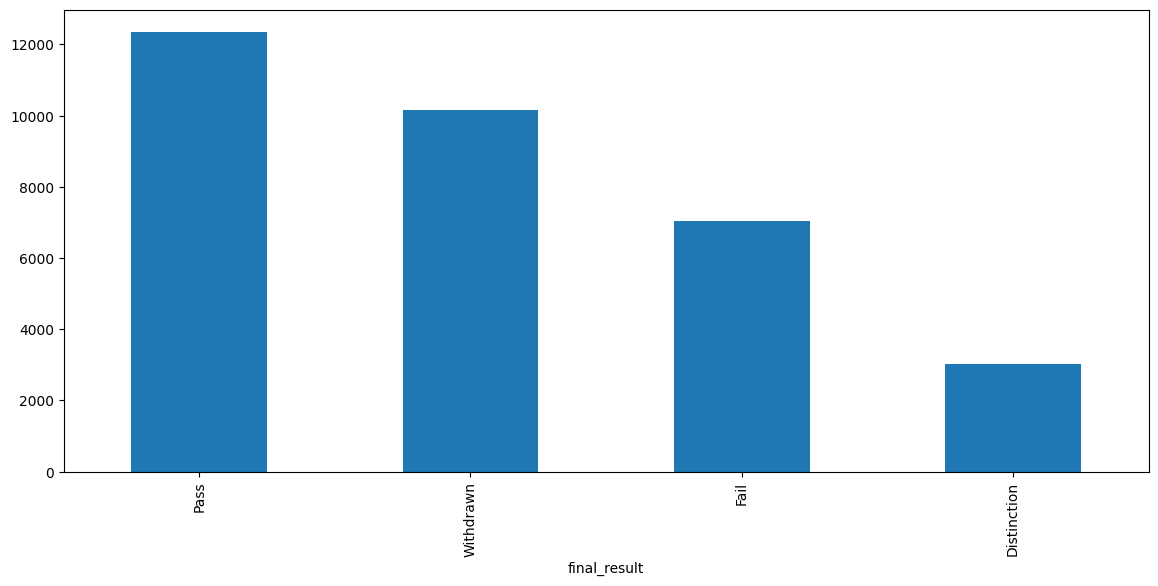

In [55]:
# In this research, the target variable is the final_result, which will result in a binary classification problem.
print(studentInfo["final_result"].unique())
studentInfo['final_result'].value_counts().plot(kind='bar', figsize=(14, 6)) 

In this dataset, there are 7 types of courses: AAA-GGG. If you want to consider all the courses, use "ALL", ohterwise mention the specific course code that you want to use. The following observations are made based on the scenario where all the courses are considered.

In [56]:
courseId = 'ALL' # change this according to the course you want to analyze
if courseId == 'ALL':
  dataset_studentInfo = studentInfo.copy()
  dataset_studentVle = studentVle.copy()
  dataset_studentRegistration = studentRegistration.copy()
else:
  dataset_studentInfo = studentInfo[studentInfo['code_module'] == courseId]
  dataset_studentVle = studentVle[studentVle['code_module'] == courseId]
  dataset_studentRegistration = studentRegistration[studentRegistration['code_module'] == courseId]

print(f'The shape of the dataset is: {dataset_studentInfo.shape}')
dataset_studentInfo.head(10)

The shape of the dataset is: (32593, 12)


,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass
5,AAA,2013J,38053,M,Wales,A Level or Equivalent,80-90%,35-55,0,60,N,Pass
6,AAA,2013J,45462,M,Scotland,HE Qualification,30-40%,0-35,0,60,N,Pass
7,AAA,2013J,45642,F,North Western Region,A Level or Equivalent,90-100%,0-35,0,120,N,Pass
8,AAA,2013J,52130,F,East Anglian Region,A Level or Equivalent,70-80%,0-35,0,90,N,Pass
9,AAA,2013J,53025,M,North Region,Post Graduate Qualification,NaN,55<=,0,60,N,Pass


In this case, we will discard the students that withdrew in the first half of the semester, since in their case, there is nothing to predict. Moreover, we consider the students that withdrew in the second half of the semester or the ones that never withdrew. 

In [57]:
merged_studentRegistration_courses = dataset_studentRegistration.merge(courses, on=['code_module', 'code_presentation'], how='left')
merged_studentRegistration_courses
select_active_students = merged_studentRegistration_courses[
    (merged_studentRegistration_courses['date_unregistration'] > (merged_studentRegistration_courses['module_presentation_length'] / 2)) |
    pd.isna(merged_studentRegistration_courses['date_unregistration'])
]
select_active_students

,code_module,code_presentation,id_student,date_registration,date_unregistration,module_presentation_length
0,AAA,2013J,11391,-159.0,NaN,268
1,AAA,2013J,28400,-53.0,NaN,268
3,AAA,2013J,31604,-52.0,NaN,268
4,AAA,2013J,32885,-176.0,NaN,268
5,AAA,2013J,38053,-110.0,NaN,268
...,...,...,...,...,...,...
32587,GGG,2014J,2620947,-23.0,NaN,269
32588,GGG,2014J,2640965,-4.0,NaN,269
32589,GGG,2014J,2645731,-23.0,NaN,269
32590,GGG,2014J,2648187,-129.0,NaN,269


We select the VLE activities that happened just in the first half of the semester.  

In [58]:
select_active_studentVle = select_active_students.merge(studentVle, on=['id_student', 'code_presentation', 'code_module'], how='left')
print(select_active_studentVle.shape)
select_active_studentVle_activities = select_active_studentVle[
    (select_active_studentVle['date'] <= (select_active_studentVle['module_presentation_length'] / 2))
]

(10183788, 9)


# Feature engineering

### Creating the sum_click feature

The first VLE interaction feature is ”sum click”, which represents the sum of the clicks that a student made in the VLE, according to our design. We created this independent variable since it is a relevant coefficient that shows the interest of the student towards the available resources

In [59]:
sum_clicks_feature = select_active_studentVle_activities.groupby(['id_student', 'code_presentation', 'code_module'])['sum_click'].sum()
sum_clicks_feature_indexes = sum_clicks_feature.reset_index() # reset the indexes
print(sum_clicks_feature_indexes.shape)
print(sum_clicks_feature_indexes.head(5))

(24159, 4)
   id_student code_presentation code_module  sum_click
0        6516             2014J         AAA     1603.0
1       11391             2013J         AAA      710.0
2       23629             2013B         BBB      161.0
3       23698             2014J         CCC      656.0
4       23798             2013J         BBB      371.0


## Creating the consistency feature

Secondly, there is the ”consistency” variable, which represents how consistent is a student towards the interactions with the materials. To calculate it, we build a histogram to count the number of clicks for each day, from the day of the first VLE interaction, until the last one. To obtain the final feature, we calculate the standard deviation of the previously obtained array.

In [60]:
grouped_data_consistency_feature = select_active_studentVle_activities.groupby(['id_student', 'code_presentation', 'code_module'])


merged_tuples_consistency_feature = [] # empty list to store the merged tuples

for group_key, group_df in grouped_data_consistency_feature:
    id_value, code_presentation_value, code_module_value = group_key
    local_min = group_df['date'].min() # calculate the first day of activity
    local_max = group_df['date'].max() # calculate the last day of activity
    total_buckets = int(local_max - local_min + 1) # the total number of days
    histogram_array = np.zeros(total_buckets) # initialise the histogram
    indices = (group_df['date'] - local_min).astype(int)
    np.add.at(histogram_array, indices, np.array(group_df['sum_click'])) # add to the corresponding location the number of clicks from that day
    local_standard_deviation = statistics.pstdev(histogram_array) # calculate the standard deviation
    merged_tuples_consistency_feature.append((id_value, code_presentation_value, code_module_value, local_standard_deviation)) # create and append the tuple to the list

final_consistency_feature = pd.DataFrame(merged_tuples_consistency_feature, columns=['id_student', 'code_presentation', 'code_module', 'consistency']) # dataFrame from the merged tuples list

print(final_consistency_feature)

       id_student code_presentation code_module  consistency
0            6516             2014J         AAA    18.947138
1           11391             2013J         AAA    16.754419
2           23629             2013B         BBB     4.611785
3           23698             2014J         CCC    15.880548
4           23798             2013J         BBB     5.648440
...           ...               ...         ...          ...
24154     2698257             2013J         AAA     9.093142
24155     2698535             2013J         EEE    33.722040
24156     2698535             2014B         CCC    15.425469
24157     2698577             2014J         BBB    17.229053
24158     2698588             2014J         BBB     7.718504

[24159 rows x 4 columns]


Creating the dataset used in the creation of assessment related features. This step represents merging multiple tables, to obtain a single table with all the necessary features.

In [61]:
assessments_copy = assessments.copy() # copy of assessements
assessments_processed = assessments_copy # Missing values: 11 'date' missing values. All of them are exams

studentAssessement_copy = studentAssessment.copy() # copy of student assessments
studentAssessement_processed = studentAssessement_copy.dropna(subset=['score']) # there are 173 score values that are missing. All of them come from TMA assessments and we will drop them

merged_assessment_studentAssessement = studentAssessement_processed.merge(assessments_processed, on=['id_assessment'], how='left')


merged_assessment_studentAssessement_courses = merged_assessment_studentAssessement.merge(courses, on=['code_module', 'code_presentation'], how='left')
merged_assessment_studentAssessement_courses_active = merged_assessment_studentAssessement_courses[
    (merged_assessment_studentAssessement_courses['date_submitted'] <= (merged_assessment_studentAssessement_courses['module_presentation_length'] / 2))] # only the assessments from the first half of the course
final_active_assessments = merged_assessment_studentAssessement_courses_active.copy()
print(f'The shape of the dataset is: {final_active_assessments.shape}')

The shape of the dataset is: (97400, 11)


# Creating the features related to assessments

There are two types of assessments, these being Tutor Marked Assessment (TMA) and Computer
Marked Assessment (CMA). There can be multiple assignments of each type during a single course,
but their importance in the final grade is given by a given weight. To start with, we have two features in
which we don’t take into consideration the weight, these being ”TMA average” and ”CMA average”.
These independent variables are obtained by calculating the total sum of the ratings and the total amount of graded assessments for each of the 2 types. Furthermore, we divide these 2 components, obtaining the mean of the TMA and CMA results. Similar to these features is the ”Total average score” attribute, which is the overall sum of the scores from all the assessments, divided
by the total number of graded assignments. We use these features since we believe that a student who
shows constant good results in all the assignments will have greater chances of passing and otherwise,
we expect the opposite. Moreover, we have the ”TMA score” and ”CMA score” variables. These are
calculated by summing the product of the score of an assignment, with the corresponding weight. In
this way, we obtain the values that will be used in calculating the assignment result component from
the final grade in the course. Moreover, we have the ”Total assessment score” feature, representing
the final assessment grade, which represents the sum of the ”TMA score” and ”CMA score”. This
group of features is highly correlated with each other, but we believe that a decisive predictor when
forecasting future achievement is the situations when the student was previously marked. Lastly,
there is the ”submission date average”, which is obtained by calculating the sum of the difference
between the submission date of the homework and the deadline and dividing it by the overall amount
of assessments. In this way, we try to understand if the behaviour related to the submission moment
is important. This concludes with 7 features related to assessments and all of them were obtained by
performing different calculations using the information from the dataset.

In [62]:
copy_main_dataset = final_active_assessments.copy() # copy of the current main dataset

grouped_data_assessments_feature = copy_main_dataset.groupby(['id_student', 'code_presentation', 'code_module'])

merged_tuples_assessments_feature = [] # empty list to store the merged tuples

for group_key, group_df in grouped_data_assessments_feature:
  id_value, code_presentation_value, code_module_value = group_key

  # initialise the variable for calculating the features
  days_difference = 0
  TMA_average = 0
  CMA_average = 0
  TMA_total = 0
  CMA_total = 0
  TMA_count = 0
  CMA_count = 0
  TMA_score = 0
  CMA_score = 0
  Total_average_score = 0
  Total_assessment_score = 0

  TMA_count = sum(group_df['assessment_type'].apply(lambda x: 1 if x == 'TMA' else 0)) # calculate the total TMA done assessments
  TMA_total = sum(group_df['score'].where(group_df['assessment_type'] == 'TMA', 0)) # calculate the total sum of the scores for the TMA assessments
  TMA_score = sum(group_df.apply(lambda row: row['weight'] * row['score'] if row['assessment_type'] == 'TMA' else 0, axis=1)) # calculate what is the value used in calculating the final grade from TMA ( with weight )
  CMA_count = sum(group_df['assessment_type'].apply(lambda x: 1 if x == 'CMA' else 0)) # calculate the total CMA done assessments
  CMA_total = sum(group_df['score'].where(group_df['assessment_type'] == 'CMA', 0)) # calculate the total sum of the scores for the CMA assessments
  CMA_score = sum(group_df.apply(lambda row: row['weight'] * row['score'] if row['assessment_type'] == 'CMA' else 0, axis=1)) # calculate what is the value used in calculating the final grade from CMA ( with weight )
  days_difference = sum(group_df.apply(lambda row: row['module_presentation_length'] if row['date'] == 0 else row['date_submitted'] - row['date'], axis=1)) # calculates the number of days difference between the deadline and submitted ( negative value is better )

  Total_average_score = (TMA_total + CMA_total) / (CMA_count + TMA_count) if (CMA_count + TMA_count) != 0 else 0 # calculate the total average assessment score
  Total_assessment_score = TMA_score + CMA_score # calculate the total value of the assessments that will be used in calculating the final score of a student
  submission_date_average = days_difference / (CMA_count + TMA_count) if (CMA_count + TMA_count) != 0 else group_df.loc[group_df.index[0], 'module_presentation_length'] # calculate the average number of days by dividing it to the total number of submitted assessments
  TMA_average = TMA_total / TMA_count if TMA_count != 0 else 0 # plain average of the TMA assessments, without weight
  CMA_average = CMA_total / CMA_count if CMA_count != 0 else 0 # plain average of the CMA assessments, without weight

  merged_tuples_assessments_feature.append((id_value, code_presentation_value, code_module_value, TMA_average, CMA_average,  TMA_score, CMA_score,  Total_average_score,  Total_assessment_score, submission_date_average)) # create and append the tuple to the list


final_assessments_feature = pd.DataFrame(merged_tuples_assessments_feature, columns=['id_student', 'code_presentation', 'code_module', 'TMA_average', 'CMA_average', 'TMA_score', 'CMA_score',  'Total_average_score', 'Total_assessment_score', 'submission_date_average']) # dataFrame from the merged tuples list for assessments features

## Appending the created features

Merge all the necesssary features into one dataframe.

In [63]:
dataset_studentInfo_processed_sumClicks = select_active_students.merge(sum_clicks_feature_indexes, on=['id_student', 'code_module', 'code_presentation'], how='left') # add sum_clicks feature to the table
# 24601 rows × 7 columns

dataset_studentInfo_processed_sumClicks_consistency  =  dataset_studentInfo_processed_sumClicks.merge(final_consistency_feature, on=['id_student', 'code_module', 'code_presentation'], how='left') # add consistency feature to the table
# 24601 rows × 8 columns

dataset_studentInfo_processed_sumClicks_consistency_assessments = dataset_studentInfo_processed_sumClicks_consistency.merge(final_assessments_feature,on=['id_student', 'code_module', 'code_presentation'], how='left') # add assessments feature to the table ( 7 features )
# 24601 rows × 15 columns

merged_studentInfo_select_active_students = pd.merge(studentInfo, select_active_students, on=['id_student', 'code_module', 'code_presentation'], how='inner')
# 24601 rows × 15 columns

# delete the rows that are not necessary
merged_studentInfo_select_active_students = merged_studentInfo_select_active_students.drop('date_registration', axis=1)
merged_studentInfo_select_active_students = merged_studentInfo_select_active_students.drop('date_unregistration', axis=1)
merged_studentInfo_select_active_students = merged_studentInfo_select_active_students.drop('module_presentation_length', axis=1)


final_dataset_feature_engineering = merged_studentInfo_select_active_students.merge(dataset_studentInfo_processed_sumClicks_consistency_assessments, on=['id_student', 'code_module', 'code_presentation'], how='left')
# 24601 rows × 24 columns

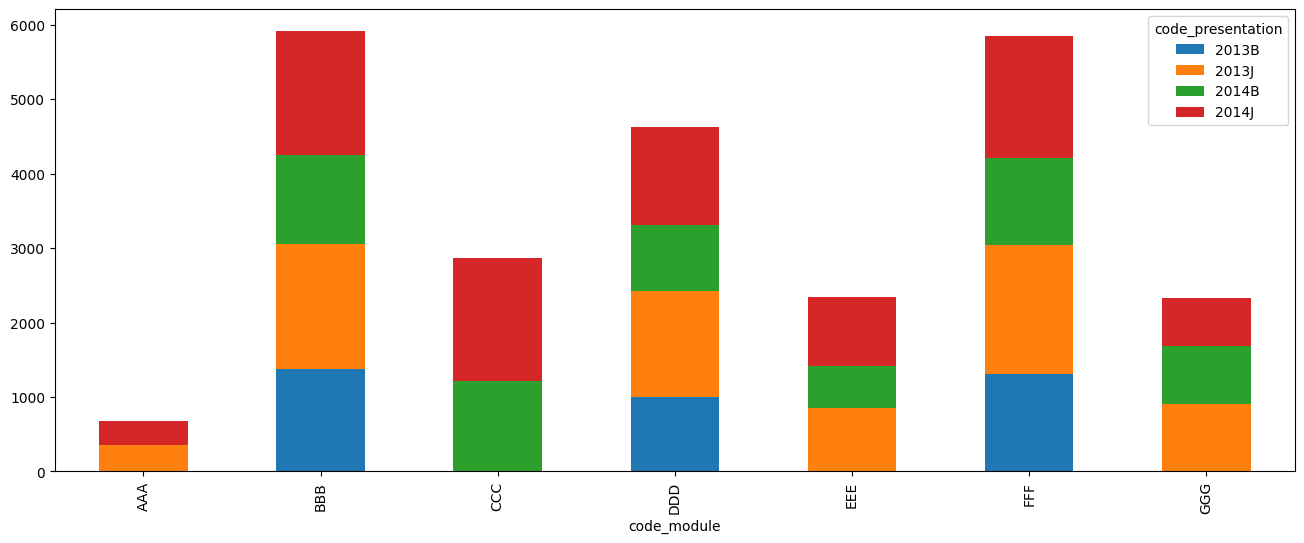

In [64]:
# the current distribution of students from the final dataset in the 7 courses
grouped = final_dataset_feature_engineering.groupby(['code_module',	'code_presentation']).size().unstack().plot(kind='bar', stacked=True, figsize=(16, 6)) # number of students in each course

In [65]:
# delete all the unnecessary columns
final_dataset = final_dataset_feature_engineering.copy()
final_dataset = final_dataset.drop('date_registration', axis=1)
final_dataset = final_dataset.drop('date_unregistration', axis=1)
final_dataset = final_dataset.drop('module_presentation_length', axis=1)
final_dataset = final_dataset.drop('region', axis=1)
final_dataset = final_dataset.drop('code_module', axis=1)
final_dataset = final_dataset.drop('code_presentation', axis=1)
final_dataset = final_dataset.drop('id_student', axis=1)
final_dataset
# 24601 rows × 17 columns

,gender,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,sum_click,consistency,TMA_average,CMA_average,TMA_score,CMA_score,Total_average_score,Total_assessment_score,submission_date_average
0,M,HE Qualification,90-100%,55<=,0,240,N,Pass,710.0,16.754419,81.000000,0.0,4080.0,0.0,81.000000,4080.0,-1.333333
1,F,HE Qualification,20-30%,35-55,0,60,N,Pass,986.0,15.279285,69.333333,0.0,3460.0,0.0,69.333333,3460.0,1.666667
2,F,A Level or Equivalent,50-60%,35-55,0,60,N,Pass,1382.0,14.551545,72.333333,0.0,3620.0,0.0,72.333333,3620.0,-2.333333
3,F,Lower Than A Level,50-60%,0-35,0,60,N,Pass,799.0,13.276953,54.000000,0.0,2550.0,0.0,54.000000,2550.0,11.666667
4,M,A Level or Equivalent,80-90%,35-55,0,60,N,Pass,1312.0,15.250278,74.000000,0.0,3650.0,0.0,74.000000,3650.0,3.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24596,F,A Level or Equivalent,80-90%,0-35,0,30,Y,Distinction,182.0,4.843826,82.500000,100.0,0.0,0.0,88.333333,0.0,-41.000000
24597,F,Lower Than A Level,10-20,0-35,0,30,N,Fail,41.0,4.586930,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24598,F,Lower Than A Level,40-50%,35-55,0,30,N,Distinction,304.0,14.557052,80.500000,100.0,0.0,0.0,87.000000,0.0,-38.000000
24599,F,A Level or Equivalent,20-30%,0-35,0,30,Y,Pass,132.0,4.760557,70.000000,60.0,0.0,0.0,65.000000,0.0,-66.000000


## Data cleaning

Cleaning the rows that have na values and can't be used in the models or changing their value to 0.

In [66]:
# We check for empty values in the final dataset. 
nan_values = final_dataset.isna().sum()
if np.any(nan_values):
    print("There are missing values in the dataframe:")
    print(nan_values)
else:
    print("No missing values found in the dataframe.")

There are missing values in the dataframe:
gender                        0
highest_education             0
imd_band                    940
age_band                      0
num_of_prev_attempts          0
studied_credits               0
disability                    0
final_result                  0
sum_click                   442
consistency                 442
TMA_average                1546
CMA_average                1546
TMA_score                  1546
CMA_score                  1546
Total_average_score        1546
Total_assessment_score     1546
submission_date_average    1546
dtype: int64


There are 940 missing imd_band values. These rows will be deleted. On the other hand, there are 442 missing sum_click and consistency values and there are 1546 rows that have missing assessments related values. These rows will be filled with 0.

In [67]:
final_dataset_processed = final_dataset.dropna(subset=['imd_band'])
final_dataset_processed_clean = final_dataset_processed.fillna(0, inplace=False)
nan_values = final_dataset_processed_clean.isna().sum()
if np.any(nan_values):
    print("There are missing values in the dataframe:")
    print(nan_values)
else:
    print("No missing values found in the dataframe.")

No missing values found in the dataframe.


In [68]:
print(final_dataset_processed_clean.shape) # There are 16 features and the "final_result" column which is the target variable
final_dataset_processed_clean 

(23661, 17)


,gender,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,sum_click,consistency,TMA_average,CMA_average,TMA_score,CMA_score,Total_average_score,Total_assessment_score,submission_date_average
0,M,HE Qualification,90-100%,55<=,0,240,N,Pass,710.0,16.754419,81.000000,0.0,4080.0,0.0,81.000000,4080.0,-1.333333
1,F,HE Qualification,20-30%,35-55,0,60,N,Pass,986.0,15.279285,69.333333,0.0,3460.0,0.0,69.333333,3460.0,1.666667
2,F,A Level or Equivalent,50-60%,35-55,0,60,N,Pass,1382.0,14.551545,72.333333,0.0,3620.0,0.0,72.333333,3620.0,-2.333333
3,F,Lower Than A Level,50-60%,0-35,0,60,N,Pass,799.0,13.276953,54.000000,0.0,2550.0,0.0,54.000000,2550.0,11.666667
4,M,A Level or Equivalent,80-90%,35-55,0,60,N,Pass,1312.0,15.250278,74.000000,0.0,3650.0,0.0,74.000000,3650.0,3.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24596,F,A Level or Equivalent,80-90%,0-35,0,30,Y,Distinction,182.0,4.843826,82.500000,100.0,0.0,0.0,88.333333,0.0,-41.000000
24597,F,Lower Than A Level,10-20,0-35,0,30,N,Fail,41.0,4.586930,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000
24598,F,Lower Than A Level,40-50%,35-55,0,30,N,Distinction,304.0,14.557052,80.500000,100.0,0.0,0.0,87.000000,0.0,-38.000000
24599,F,A Level or Equivalent,20-30%,0-35,0,30,Y,Pass,132.0,4.760557,70.000000,60.0,0.0,0.0,65.000000,0.0,-66.000000


<Axes: xlabel='final_result'>

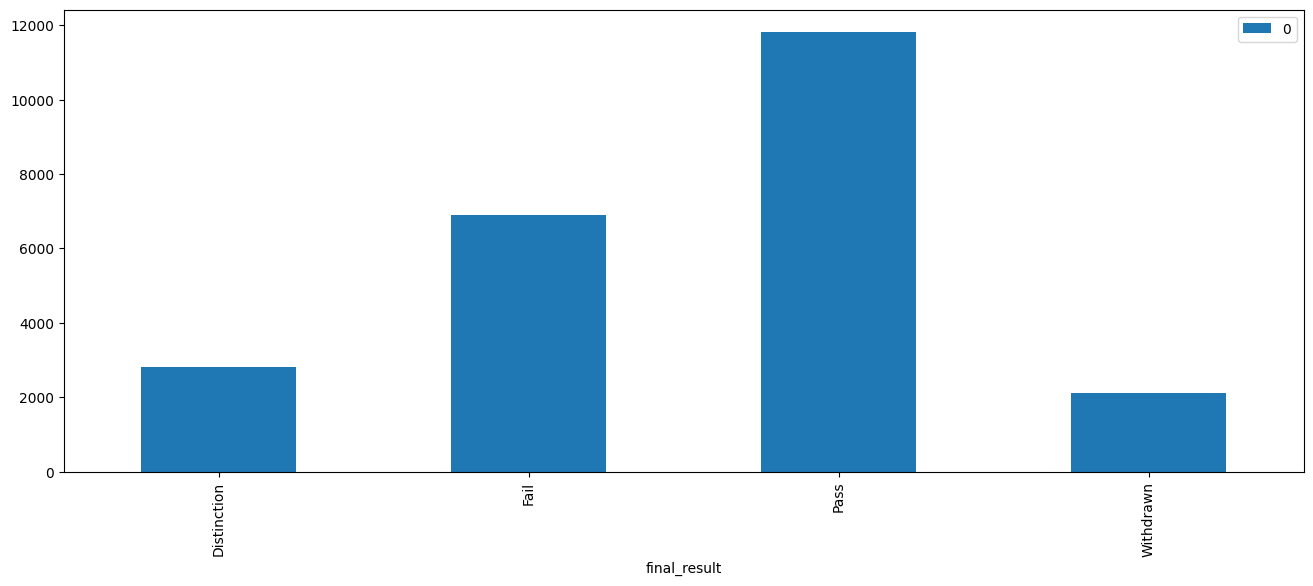

In [69]:
# distribution of final_result in the final dataset
grouped = final_dataset_processed_clean.pivot_table(index='final_result', aggfunc='size').reset_index()
grouped.plot(x='final_result', kind='bar', stacked=True, figsize=(16, 6))

In [70]:
data = final_dataset_processed_clean.copy()

# Data encoding

We will encode the data to be used by the ML models.

In [71]:
# Perform binary encoding for gender, disability and final_result
binary_encoding = {'gender': {'M': 1, 'F': 0}, 'disability': {'N': 0, 'Y': 1}} # binary endode gender and dissability
data_encoded = data.replace(binary_encoding)
label_encoding = {'final_result':{'Fail': 0, 'Withdrawn':0, 'Pass':1, 'Distinction':1}, 
                  'highest_education': {'No Formal quals': 0, 'Lower Than A Level': 1, 'A Level or Equivalent':2, 'HE Qualification':3, 'Post Graduate Qualification':4}}
# label encoding for final_result and highest_education. Important that "Distinction" and "Pass" are encoded as 1, and "Fail" and "Withdrawn" as 0.
data_encoded.replace(label_encoding, inplace=True)

Since imd_band and age_band have a hierarchical order, we can use ordinal encoding.

In [72]:
local_copy = data_encoded.copy()
ordinal_encoder = OrdinalEncoder()

# Fit and transform the categorical column(s) using ordinal encoding
encoded_imd_band = ordinal_encoder.fit_transform(local_copy[['imd_band']])
local_copy['imd_band'] = encoded_imd_band

imd_band_mapping = ordinal_encoder.categories_[0]

print("Mapping for imd_band:")
for i, category in enumerate(imd_band_mapping):
    print(f"{i}: {category}")

encoded_age_band = ordinal_encoder.fit_transform(local_copy[['age_band']])
local_copy['age_band'] = encoded_age_band

age_band_mapping = ordinal_encoder.categories_[0]

print("\nMapping for age_band:")
for i, category in enumerate(age_band_mapping):
   print(f"{i}: {category}")

data_encoded = local_copy.copy()

Mapping for imd_band:
0: 0-10%
1: 10-20
2: 20-30%
3: 30-40%
4: 40-50%
5: 50-60%
6: 60-70%
7: 70-80%
8: 80-90%
9: 90-100%

Mapping for age_band:
0: 0-35
1: 35-55
2: 55<=


In [75]:
# export encoded data to csv to be used for the ML models
data_encoded.to_csv('../50%PassFailPrediction/Q2TransitionFolder/Q2_data_encoded.csv', index=False)

In [76]:
print(data_encoded.shape)
data_encoded['final_result'].value_counts()

(23661, 17)


final_result
1    14655
0     9006
Name: count, dtype: int64